<a href="https://colab.research.google.com/github/Luis-Yovera/Deteccion_infraccion_vehicular_de_estacionamiento_en_cruce_peatonal_durante_semaforo_en_rojo/blob/PRACTICAS_U2/Copia_de_PDSeI_Practica_Redes_Neuronales_convolucionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PDSeI - Redes Neuronales convolucionales

# Integrantes:

1. Galarreta Grados, Luis Daniel Jesús

2. Recuenco Tapia, Angie Tatiana

3. Yovera Suarez, Luis Alberto


Base de datos: https://www.kaggle.com/datasets/datamunge/sign-language-mnist

# Conexión con kaggle

# Instalaciones previas

In [ ]:
!pip install -q kaggle
!pip install -q scikeras

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luizo2004","key":"b7d755043ab89dd6be842a4a5e8924c8"}'}

# Descargar la base de datos

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d datamunge/sign-language-mnist
!unzip sign-language-mnist.zip

Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
 58% 36.0M/62.6M [00:00<00:00, 194MB/s]
100% 62.6M/62.6M [00:00<00:00, 219MB/s]
Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


# Lectura de datos

In [ ]:
train_df = pd.read_csv("sign_mnist_train.csv")
test_df = pd.read_csv("sign_mnist_test.csv")

In [ ]:
print(train_df.keys())

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)


In [ ]:
# Elementos por clase

class_counts = train_df['label'].value_counts()
print(class_counts)

label
17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: count, dtype: int64


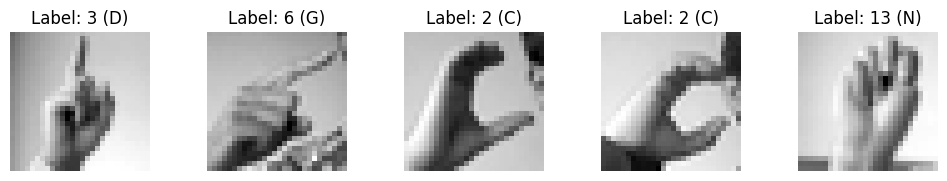

In [ ]:
import matplotlib.pyplot as plt

label_mapping = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
    10: 'K',
    11: 'L',
    12: 'M',
    13: 'N',
    14: 'O',
    15: 'P',
    16: 'Q',
    17: 'R',
    18: 'S',
    19: 'T',
    20: 'U',
    21: 'V',
    22: 'W',
    23: 'X',
    24: 'Y',
    25: 'Z'
}

def plot_images(data, labels, num=5):
    fig, axes = plt.subplots(1, num, figsize=(10, 2))
    fig.tight_layout()

    for i in range(num):
        ax = axes[i]
        ax.imshow(data[i].reshape(28, 28), cmap='gray')
        ax.set_title(f'Label: {labels[i]} ({label_mapping[labels[i]]})')
        ax.axis('off')

    plt.show()

plot_images(train_df.iloc[:, 1:].values, train_df['label'].values)

# Transformación de datos

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

batch_size = 32

X_train = train_df.iloc[:, 1:].values.reshape(-1, 28, 28, 1) / 255.0
y_train = train_df['label'].values

X_val = test_df.iloc[:, 1:].values.reshape(-1, 28, 28, 1) / 255.0
y_val = test_df['label'].values

# Data Augmentation

In [ ]:
datagen_train = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

train_generator = datagen_train.flow(
    X_train,
    y_train,
    batch_size=batch_size)

datagen_val = ImageDataGenerator()
val_generator = datagen_val.flow(X_val, y_val, batch_size=batch_size)



```
1. ¿Qué es el data augmentation y cómo puede beneficiar el entrenamiento de una CNN?
Es una técnica empleada para aumentar la cantidad y la diversidad de los datos de entrenamiento, mediante la aplicación de transformaciones a los datos existentes, mejorando la capacidad de generalización a datos no conocidos, esto beneficia al modelo a aprender características más robustas que son invariantes a estas transformaciones y, por lo tanto, reducir el riesgo de sobreajuste, ya que este, puede conducir a un rendimiento deficiente y predicciones inexactas, en modelos complejos como las redes neuronales convolucionales (CNNs).

2. ¿Por qué es importante normalizar los datos de entrada y qué impacto tiene en el rendimiento del modelo?
La normalización de los datos de entrada es esencial porque asegura que todas las características tengan un rango similar, acelerando la convergencia y estabilizando el entrenamiento. Esto evita que los gradientes se vuelvan demasiado grandes o pequeños, lo que ayuda a prevenir problemas al emplear funciones de activación. Además, reduce el riesgo de que las activaciones de las neuronas se saturen, permitiendo un aprendizaje más equilibrado y eficiente. En resumen, la normalización mejora la capacidad del modelo para generalizar, haciéndolo más robusto y preciso al enfrentar nuevos datos.
```



# Creación del modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,954 (519.35 KB)

 Trainable params: 132,954 (519.35 KB)

 Non-trainable params: 0 (0.00 B)



```
1. ¿Qué función cumplen las capas Conv2D y MaxPooling2D en una CNN?
Conv2D cumple con la función de convolución sobre la imagen de entrada, esto quiere decir que se encarga de detectar las características de una imagen, como son las texturas, patrones o bordes.
MaxPooling2D cumple con la función de agrupación o reducción de los mapas de características, generados en cada capa de convolución, mantenimendo la información más importante para disminuir la cantidad de parámetros y el coste computacional.

2. ¿Qué es el Dropout y cómo ayuda a prevenir el sobreajuste en redes neuronales?
El Dropout es una técnica de regularización basada en la omisión aleatoria (apagado aleatorio) de cada neurona de la red con el propósito de que estas no dependan o confíen demasiado en el trabajo de las otras neuronas de la misma capa oculta y aprendan patrones de generalización.
Ayuda en la prevención de sobreajustes gracias a su parámetro que debe ser ajustado cuidadosamente ya que un es muy alto falla en la captura de información importante y si es muy bajo captura el ruido y no realiza un correcto proceso de filtrado.

3. ¿Por qué se utiliza la función de activación ReLU en las capas ocultas y cuáles son sus ventajas?
Se utiliza la función ReLU porque introduce no linealidad y mejora significativamente el rendimiento y la velocidad del entrenamiento.
Sus ventajas son:
- Permite que el algoritmo converja mucho más rapido debido a la simplicidad en el cálculo, facilitando también el entrenamiento.
- Al no comprimir sus salidas entre valores específicos, evita que los gradientes sean muy pequeños y permite que la red aprenda más rápido.
- Tiene el mismo rendimiento y acciones que la función de activación lineal, por lo tanto permite la optimización del comportamiento de las redes neuronales cuando es cercano al lineal.

4. ¿Qué hace la función de activación softmax en la capa de salida y en qué tipo de problemas se utiliza comúnmente?
La función softmax en la capa de salida ejerce la función de clasificar una entrada en una de carias categorías posibles, debido a esto es que se la utiliza en problemas de clasificación multiclase.

5. ¿Qué es el tamaño del filtro (filter size) en una capa convolucional y cómo impacta la calidad de las características extraídas?
El tamaño del filtro es la dimensión de los filtros o matices que se utilizan para la extracción de características de los datos de entrada.
Impacta en la calidad de las características extraidas ya que, debido al tamaño asignado, permite identificar detalles finos o generales dependiendo del uso que se le desee dar, aumenta o disminuye la complejidad computacional, y permiten o no que la información pase por mas capas para capturar características de bajo nivel en las capas externas o de nivel superior en las capas profundas.

6. ¿Qué efecto tiene un stride mayor que 1 en la resolución de la salida de una capa convolucional?
Debido que los stride son la distancia o número de píxeles que el kernel o filtro se mueve sobre la matriz de entrada, un stride mayor a 1 permite que la salida gener auna imagen de menor tamaño en comparación a la de entrada, reduciendo en el proceso la carga computacional.

7. ¿Cómo se debe seleccionar el tamaño del filtro y el stride para optimizar el balance entre la extracción de características y la complejidad del modelo?
Para la selección del tamaño del kernel y el stride se debe considerar tres factores: el tipo de datos a analizar, la tarea específica a realizar ( que jutno al tipo de dato podemos determinar el detalle deseado en la extracción de características) y los recursos computacionales. Para esto, se recomiendan las siguientes consideraciones:
- Iniciar probando con valores pequeños los filtros y strides.
- Utilizar filtros pequeños apilados (dos filtros 3x3 en lugar de uno 5x5).
- Aumentar el valor del stride conforme aumente la profundidad de la capa.
```



# Terminación anticipada y Checkpoints

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')

In [ ]:
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_val_accuracy = -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get('val_accuracy')

        if current_val_accuracy and current_val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = current_val_accuracy
            print(f" Modelo guardado época {epoch + 1} con exactitud: {current_val_accuracy:.4f}")

        super().on_epoch_end(epoch, logs)

custom_model_checkpoint = CustomModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')



```
1. ¿Qué es el EarlyStopping y cómo contribuye a mejorar el proceso de entrenamiento de un modelo?
También conocida como "parada temprana", el EarlyStopping es una técnica, que se basa en detener el entrenamiento al momento que se observe un incremento en el valor del error de validación. Con ello, se logra entrenar el modelo para que este error sea mínimo y por consiguiente su precisión sea máxima, reduciendo así el overfitting.

2. ¿Cuál es la función de ModelCheckpoint y por qué es útil guardar el mejor modelo durante el entrenamiento?
Es una función empleada para guardar el estado de un modelo en diferentes puntos durante el entrenamiento, especialmente cuando se alcanza un nuevo mejor rendimiento. Es útil porque permite guardar el "mejor modelo", es decir, el modelo con los parámetros óptimos, basados en una métrica especificada (por ejemplo, la precisión o la pérdida de validación).
```



# Entrenamiento

In [ ]:
epochs = 7

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    # callbacks=[early_stopping, model_checkpoint]
    callbacks=[early_stopping, custom_model_checkpoint]
)

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


856/858 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1370 - loss: 2.8477 Modelo guardado época 1 con exactitud: 0.5410
858/858 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.1374 - loss: 2.8461 - val_accuracy: 0.5410 - val_loss: 1.3726
Epoch 2/7
850/858 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5145 - loss: 1.4425 Modelo guardado época 2 con exactitud: 0.8072
858/858 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.5149 - loss: 1.4408 - val_accuracy: 0.8072 - val_loss: 0.6382
Epoch 3/7
850/858 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6609 - loss: 0.9886 Modelo guardado época 3 con exactitud: 0.8162
858/858 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.6611 - loss: 0.9881 - val_accuracy: 0.8162 - val_loss: 0.5280
Epoch 4/7
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7242 - loss: 0.7790 Modelo guardado época 4 con exactitud: 0.8731
858/858 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7242 - loss: 0.7789 - val_accuracy: 0.8731 - val_loss: 0.3729
Epoch 



```
1. ¿Qué significa el parámetro epochs y cómo afecta al entrenamiento de un modelo?
Epoch es el número de veces que el modelo verá el conjunto completo de datos de entrenamiento durante el proceso de aprendizaje, es decir,una pasada completa del conjunto de datos de entrenamiento por el algoritmo. Determinan cuánto tiempo se entrena el modelo y cómo se actualizan los pesos de los parámetros, ya que muy pocos epochs, el modelo puede no aprender lo suficiente y tener un bajo rendimiento; y si son demasiados, el modelo puede sobreajustarse a los datos de entrenamiento y perder generalización. Para encontrar el número óptimo, se puede usar una técnica llamada early stopping.

2. ¿Cuál es la diferencia entre train_generator y val_generator en el contexto del entrenamiento y la validación del modelo?
En dicho contexto, el train_generator proporciona los datos de entrenamiento, permitiendo que el modelo ajuste sus pesos al ver y aprender de estos datos. Este generador puede aplicar técnicas de data augmentation (como rotaciones o escalado) para aumentar la variedad de los datos y mejorar la robustez del modelo. Minetras que el val_generator suministra los datos de validación, que el modelo no usa para ajustar pesos, sino para evaluar su rendimiento en datos que no ha visto durante el entrenamiento. Esto ayuda a medir la capacidad de generalización del modelo y a detectar problemas de sobreajuste.
```



# Predicciones

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


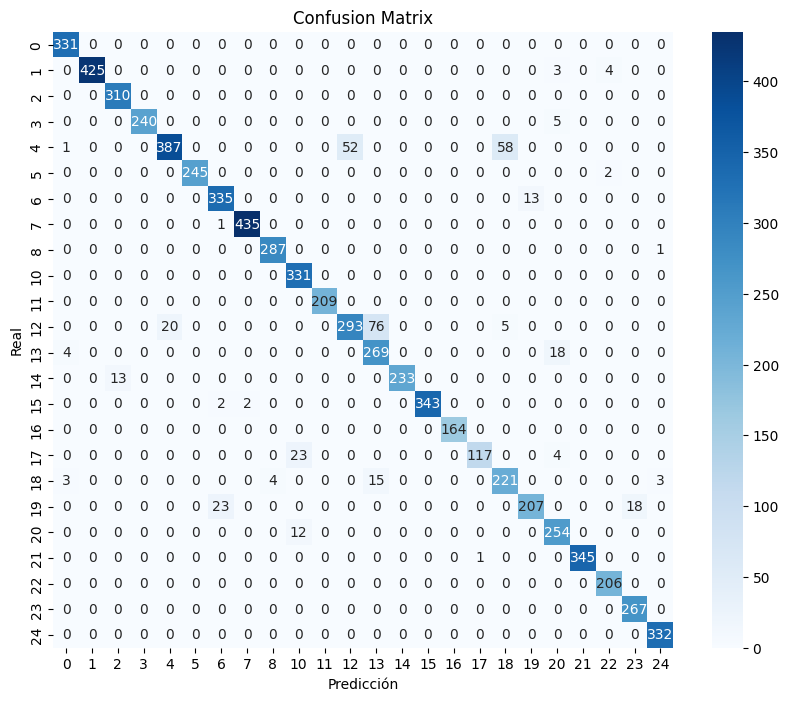

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       331
           1       1.00      0.98      0.99       432
          10       0.96      1.00      0.98       310
          11       1.00      0.98      0.99       245
          12       0.95      0.78      0.86       498
          13       1.00      0.99      1.00       247
          14       0.93      0.96      0.94       348
          15       1.00      1.00      1.00       436
          16       0.99      1.00      0.99       288
          17       0.90      1.00      0.95       331
          18       1.00      1.00      1.00       209
          19       0.85      0.74      0.79       394
           2       0.75      0.92      0.83       291
          20       1.00      0.95      0.97       246
          21       1.00      0.99      0.99       347
          22       1.00      1.00      1.00       164
          23       0.99      0.81      0.89       144
          24       0.78    

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

best_model = load_model('best_model.keras')

X_test = test_df.iloc[:, 1:].values.astype('float32') / 255.0
y_test = test_df['label'].values

X_test = X_test.reshape(-1, 28, 28, 1)

predictions = best_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, predicted_classes, target_names=np.unique(y_test.astype(str))))

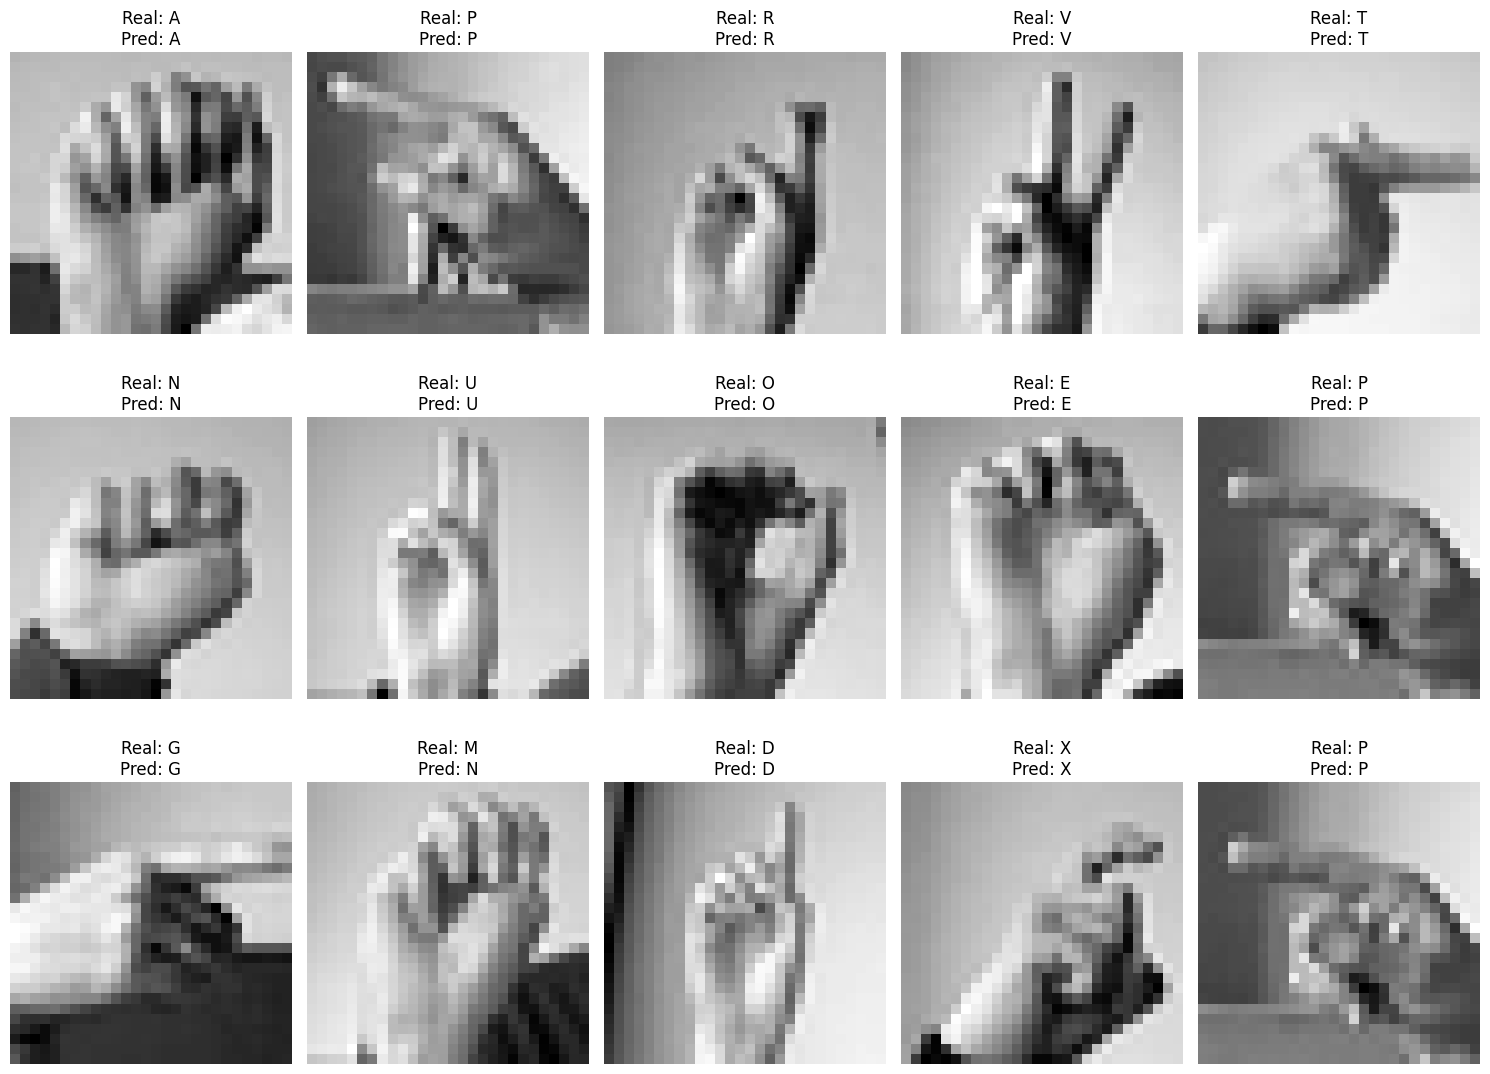

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_images_to_show = 15
indices = np.random.choice(len(X_test), num_images_to_show, replace=False)
images_per_row = 5

plt.figure(figsize=(15, 15))
for i, idx in enumerate(indices):
    plt.subplot(num_images_to_show // images_per_row + 1, images_per_row, i + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Real: {label_mapping[y_test[idx]]}\nPred: {label_mapping[predicted_classes[idx]]}')
    plt.axis('off')

plt.tight_layout()
plt.show()



```
1. ¿Qué es el confusion_matrix y qué información proporciona sobre el rendimiento del modelo?
Una matriz de confusión es una matriz que permite la visualización para los resultados del algoritmo clasificador, permitiendo la evaluación que mide el rendimiento de un método de clasificación.En esta matriz las filas representan las clases reales y las columnas las predicciones del modelo.

2. ¿Cómo se interpreta el classification_report y qué métricas se incluyen en él?
Se interpreta como un informe de texto que muestra las principales métricas de clasificación. Presenta información detallada sobre la precisión del modelo para cada clase, lo cual es especialmente útil para evaluar modelos de clasificación multiclase o cuando hay un desbalance de clases.
Métricas:
-Precisión: es utilizada para poder saber qué porcentaje de valores que se han clasificado como positivos son realmente positivos.
-Accuracy:representa el porcentaje total de valores correctamente clasificados, tanto positivos como negativos.
-Recall: es conocida como el ratio de verdaderos positivos, es utilizada para saber cunátos valores positivos son correctamente clasificados.
- F1 Score: es la media armónica entre la precision y el recall, para obtener un valor mucho más objetivo.

3. ¿Por qué es importante utilizar el conjunto de prueba (X_test y y_test) para evaluar el modelo?
Evaluar el rendimiento en el conjunto de prueba permite obtener una medida más realista de cómo el modelo se comportará en datos nuevos y en situaciones del mundo real. E crucial para evaluar el rendimiento real de un modelo, ya que contiene datos que el modelo no ha visto antes, lo que permite medir su capacidad de generalización. Usarlo evita el overfitting y asegura que el modelo funcione bien en datos nuevos.

4. ¿Qué rol juega la función np.argmax en el proceso de obtención de clases predichas?
Esta función permitirá encontrar el índice máximo de matrices, es decir ayudará a obtener el índice de la clase con la probabilidad más alta en las predicciones de un modelo.

5. ¿Qué información visual adicional proporciona un mapa de calor (heatmap) de la matriz de confusión?
Un heatmap es una representación gráfica de datos donde los valores son representdos mediante colores. En el caso de la matriz de confusión, este mapa mejorará la visualización de errores. Los colores se definirán en función del valor que se obtiene en la matriz normalizada.
```



# Refinamiento

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input
from scikeras.wrappers import KerasClassifier

def create_model(optimizer='adam', **kwargs):
    dropout_rate = kwargs.get('dropout_rate', 0.5)
    model = Sequential([
        Input((28, 28, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(26, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
from sklearn.model_selection import GridSearchCV

epochs = 2
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=32, verbose=0)

param_grid = {
    'model__optimizer': ['SGD', 'Adam'],
    'model__dropout_rate': [0.2, 0.5, 0.7]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train, y_train)

print(f"Mejor: {grid_result.best_score_} usando {grid_result.best_params_}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Mejor: 0.9792747741913134 usando {'model__dropout_rate': 0.2, 'model__optimizer': 'Adam'}


In [ ]:
val_accuracy = grid_result.best_estimator_.score(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy}")

Validation Accuracy: 0.889431121026213




```
1. ¿Qué es GridSearchCV y cómo se utiliza para optimizar el rendimiento de un modelo?
Es una técnica de validación perteneciente al paquete scikit learn. Y tiene por función hallar la mejor combinación de valores de hiperparámetros para un modelo y poder extraer los mejores valores y combinaciones de parámetros.

2. ¿Qué representan los parámetros en param_grid y por qué es importante ajustar el optimizador y la tasa de dropout?
Representan todas las listas de opciones que queremos probar para realizar el ajuste de los datos.
Es importante el ajuse del optimizador debio que, al ser este el encargado de minimizar la función de pérdida, un mal ajuste puede provocar una disminución en el desempeño y velocidad de la red, afectando en el aprendizaje de esta.  En el caso de la tasa de dropout, al ser esta la función de apagado de neuronas para evitar Overfitting, es importante su ajuste ya que al no estar correctamente calibrada puede fallar en la captura de información importante o captar ruido y no filtrar correctamente.

3. ¿Qué significa el parámetro cv=3 en el contexto de la validación cruzada y cómo influye en la evaluación del modelo?
El parámetro cv=3 significa la división del conjunto de datos en 3 partes para su póstuma iteración, en donde se seleccionará una de las 3 como conjunto de validación y las otras dos partes como conjunto de entrenamiento.
Esto influye en la evaluación del modelo ya que al realizar esta partición se obtiene estimaciones precisas y estables del rendimiento del modelo debido a que en lugar de realizar un solo análisis a un conjunto de validación y uno de entrenamiento, se realiza tres veces rotando entre los tres conjuntos.
```



# Temas grupales

1. Arquitectura de Redes Neuronales Convolucionales
2. Funciones de Activación en CNN
3. Técnicas de Preprocesamiento de Imágenes
4. Entrenamiento y Optimización de Modelos
5. Regularización en CNN
6. Evaluación de Modelos CNN
7. Aplicaciones de Redes Neuronales Convolucionales

Ejemplo:



```
Arquitectura de Redes Neuronales Convolucionales
(Autor/es): [Nombres de los estudiantes del grupo]
Contenido:
Este tema abarca la estructura fundamental de las redes neuronales convolucionales, que incluye las siguientes capas:

Capas Convolucionales: Estas capas son responsables de extraer características relevantes de las imágenes mediante la aplicación de filtros (kernels) que realizan operaciones de convolución.

Capas de Pooling: Se utilizan para reducir la dimensionalidad de las características extraídas, manteniendo las más importantes. Las capas de pooling ayudan a hacer que el modelo sea menos sensible a pequeñas variaciones en las imágenes.

Capas Totalmente Conectadas: Estas capas se encuentran al final de la red y son responsables de la clasificación final de las características extraídas. Conectan todas las neuronas de la capa anterior a cada neurona de la capa siguiente.

<img_url>: [URL de una imagen de arquitectura de CNN]

Referencias: [Referencia bibliográfica o enlace a un recurso]
```

